# Normal MLE

In [1]:
using Optim
using Statistics
using Distributions
using Plots
using LinearAlgebra

In [2]:
data = randn(100) .* 0.5 .+  1. ;

In [3]:
likelihood = (μ, σ) -> logpdf.( Normal(μ, σ), data ) |> sum
f = (p) -> -likelihood(p[1], p[2])
res = optimize(f, [-Inf, 1e-6], [Inf, Inf],  [0.0, 1.0], Fminbox(LBFGS()), autodiff = :forward)

 * Status: success

 * Candidate solution
    Minimizer: [9.33e-01, 5.05e-01]
    Minimum:   7.366251e+01

 * Found with
    Algorithm:     Fminbox with L-BFGS
    Initial Point: [0.00e+00, 1.00e+00]

 * Convergence measures
    |x - x'|               = 5.43e-10 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.12e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.84e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.86e-16 ≰ 0.0e+00
    |g(x)|                 = 2.10e-10 ≤ 1.0e-08

 * Work counters
    Seconds run:   2  (vs limit Inf)
    Iterations:    4
    f(x) calls:    196
    ∇f(x) calls:   196


In [4]:
mean(data)

0.9328596990037146

In [5]:
std(data)

0.5079926618388317

In [6]:
Optim.minimizer(res)

2-element Array{Float64,1}:
 0.9328596990037143
 0.5054463166722577

# MvNormal MLE using over-parameterization

In [7]:
data = rand(MvNormal([1.; 1.], [1. 0.5; 0.5 1.]), 100)

2×100 Array{Float64,2}:
 0.624657  0.951313  1.04176  1.47361   …  2.76285  -0.320447  0.216333
 1.03725   1.16691   2.42946  0.387327     2.03342   0.470565  0.794415

In [8]:
likelihood = (μ, Σ) -> begin
    dist = MvNormal(μ, Σ)
    sum([logpdf(dist, data[:, i]) for i in 1:size(data, 2)])
end

#7 (generic function with 1 method)

In [9]:
f = (p) -> begin
    μ = p[1:2]
    f = reshape(p[3:6], 2, 2)
    Σ = f' * f
    -likelihood(μ, Σ)
end

#11 (generic function with 1 method)

In [10]:
x0 = [0., 0., 1., 0., 0., 1.]
res = optimize(f, x0, LBFGS(), autodiff=:forward)

 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [9.42e-01, 8.06e-01, 8.68e-01,  ...]
    Minimum:   2.486111e+02

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 1.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.51e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.67e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.42e-13 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.72e-16 ≰ 0.0e+00
    |g(x)|                 = 1.19e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    14
    f(x) calls:    47
    ∇f(x) calls:   47


In [11]:
μ_hat = Optim.minimizer(res)[1:2]
f = reshape(Optim.minimizer(res)[3:6], 2, 2)
Σ_hat = f' * f

2×2 Array{Float64,2}:
 0.798341  0.39631 
 0.39631   0.816564

In [12]:
μ_hat

2-element Array{Float64,1}:
 0.9416516365632621
 0.8059733390223162

In [13]:
mean(data, dims=2)

2×1 Array{Float64,2}:
 0.9416516369020049
 0.8059733394231644

In [14]:
cov(data, dims=2)

2×2 Array{Float64,2}:
 0.806405  0.400313
 0.400313  0.824812

# MvNormal MLE using Cholesky parameterization

In [15]:
using Distributions.PDMats

In [16]:
f = (p) -> begin
    μ = p[1:2]
    Σ = PDMat(Cholesky([p[3] p[4]; 0 p[5]], 'U', 0))
    dist = MvNormal(μ, Σ)
    -sum([logpdf(dist, data[:, i]) for i in 1:size(data, 2)])
end

#13 (generic function with 1 method)

In [17]:
x0 = [0., 0., 1., 0., 1.]
lower = [-Inf, -Inf, 0, -Inf, 0]
upper = [Inf, Inf, Inf, Inf, Inf]
res = optimize(f, lower, upper, x0, Fminbox(LBFGS()), autodiff=:forward)

 * Status: success

 * Candidate solution
    Minimizer: [9.42e-01, 8.06e-01, 8.93e-01,  ...]
    Minimum:   2.486111e+02

 * Found with
    Algorithm:     Fminbox with L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 1.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.11e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.26e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.68e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.29e-16 ≰ 0.0e+00
    |g(x)|                 = 3.69e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    4
    f(x) calls:    318
    ∇f(x) calls:   318


In [18]:
p_fit = Optim.minimizer(res)
μ_fit = p_fit[1:2]
Σ_fit = PDMat(Cholesky([p_fit[3] p_fit[4]; 0 p_fit[5]], 'U', 0))

PDMat{Float64,Array{Float64,2}}(2, [0.7983405442326638 0.39630991515272923; 0.39630991515272923 0.8165635604687043], Cholesky{Float64,Array{Float64,2}}([0.8934990454570524 0.4435482244415879; 0.0 0.7872918982584661], 'U', 0))

In [19]:
μ_fit

2-element Array{Float64,1}:
 0.9416516369020044
 0.8059733394231686

In [20]:
Σ_fit.mat

2×2 Array{Float64,2}:
 0.798341  0.39631 
 0.39631   0.816564

# Mixture model MLE

In [21]:
num_arr = [50, 30, 20]
mu_arr = [-1, 0, 1]
sigma_arr = [0.2, 0.3, 0.4]

data = zeros(sum(num_arr))
idx = 1
for (num, mu, sigma) in zip(num_arr, mu_arr, sigma_arr)
    for i in 1:num
        data[idx] = randn()*sigma+mu
        idx += 1
    end
end

In [22]:
theme(:dark)

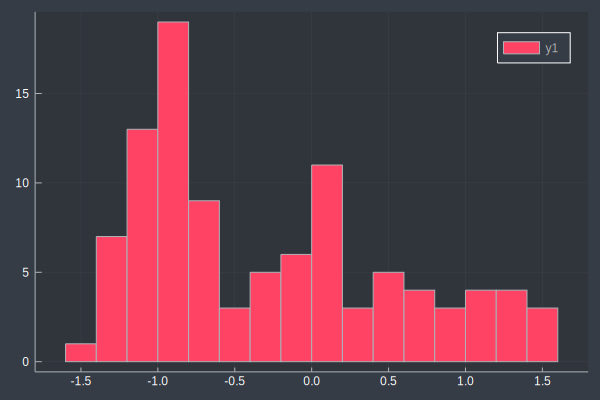

In [23]:
histogram(data, bins=20)

$$
\begin{align}
P_\theta(X) = \int_Z P_\theta(X,Z) = \int_Z P_\theta(X|Z)P(Z) 
\end{align}
$$

$$
P(X|Z)P(Z)=P(X_1,\dots,X_N|Z_1,\dots,Z_N)P(Z_1,\dots,Z_N)=(\prod P(X_i|Z_i)) (\prod P(Z_i))
$$

$$
\begin{align}
P(X) = \int_Z \prod_i P(X_i|Z_i)P(Z_i) 
&= \sum_{Z_1} \dots \sum_{Z_N} \prod_i^N P(X_i|Z_i)P(Z_i) \\
&= \sum_{Z_1} \dots \sum_{Z_{N-1}}   \prod_i^{N-1} P(X_i|Z_i)P(Z_i)  \\
&= (\sum_{Z_N} P(X_N|Z_N)P(Z_N)) \sum_{Z_1} \dots \sum_{Z_{N-1}}   \prod_i^{N-1} P(X_i|Z_i)P(Z_i) \\
&= \dots \\
&= \prod_{i} \sum_{Z_i} P(X_i|Z_i)P(Z_i)
\end{align}
$$

$$
\begin{align}
\log P(X) &= \log \prod_i \sum_{Z_i} P(X_i|Z_i)P(Z_i) \\
&= \sum_i \log \sum_{Z_i} \exp \log (P(X_i|Z_i)P(Z_i)) \\
&= \sum_i \mathrm{logsumexp}_{Z_i} \log(P(X_i|Z_i)P(Z_i))
\end{align}
$$

In [24]:
using StatsFuns

In [25]:
logsumexp([1 2 3])

3.4076059644443806

In [26]:
[1 2 3] .|> exp |> sum |> log

3.40760596444438

In [27]:
log(sum(exp.([1 2 3])))

3.40760596444438

In [28]:
likelihood = (μ_arr, σ_arr) -> begin
    dist_arr = [Normal(μ, σ) for (μ, σ) in zip(μ_arr, σ_arr)]
    num_classes = length(dist_arr)
    log_prior = log(1. / num_classes)
    lp = 0
    for d in data
        lp += logsumexp([logpdf(dist, d) + log_prior for dist in dist_arr])
    end
    lp
end

#17 (generic function with 1 method)

In [29]:
likelihood([1, 1, 1], [1, 1, 1])

-207.59091458221434

In [30]:
likelihood([-1, 0, 1], [1, 1, 1])

-140.63496716867343

In [31]:
likelihood(mu_arr, sigma_arr)

-103.40893932627914

In [32]:
encode = (p) -> (p[1:3], p[4:6])

#23 (generic function with 1 method)

In [33]:
f = (p) -> begin
    μ_arr, σ_arr = encode(p)
    -likelihood(μ_arr, σ_arr)
end

#25 (generic function with 1 method)

In [34]:
lower = [-Inf, -Inf, -Inf, 0, 0, 0]
upper = [Inf, Inf, Inf, Inf, Inf, Inf]
x0 = [randn(3); ones(3)]
res = optimize(f, lower, upper, x0, autodiff=:forward)

 * Status: success

 * Candidate solution
    Minimizer: [-3.70e-01, -1.01e+00, 7.02e-01,  ...]
    Minimum:   1.004915e+02

 * Found with
    Algorithm:     Fminbox with L-BFGS
    Initial Point: [1.14e-01, -3.57e-01, 7.81e-01,  ...]

 * Convergence measures
    |x - x'|               = 8.30e-10 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.57e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.26e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.24e-16 ≰ 0.0e+00
    |g(x)|                 = 6.52e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    4
    f(x) calls:    344
    ∇f(x) calls:   344


In [35]:
Optim.minimizer(res)

6-element Array{Float64,1}:
 -0.37044298988147994
 -1.01267871166701   
  0.7019056655903312 
  0.5083640800869492 
  0.18825829381585862
  0.5156193681707262 

In [36]:
μ_arr_fit, σ_arr_fit = encode(Optim.minimizer(res))

([-0.37044298988147994, -1.01267871166701, 0.7019056655903312], [0.5083640800869492, 0.18825829381585862, 0.5156193681707262])

In [37]:
x = range(-3, 3, length=100)

-3.0:0.06060606060606061:3.0

In [38]:
pdf_arr = [pdf.(Normal(μ,σ), x) for (μ, σ) in zip(mu_arr, sigma_arr)]

3-element Array{Array{Float64,1},1}:
 [3.8472993133532097e-22, 7.6078125022908e-21, 1.372408845984938e-19, 2.258536424078426e-18, 3.390709409718904e-17, 4.643804481873946e-16, 5.801992505420009e-15, 6.613026802451713e-14, 6.876117424567452e-13, 6.522381065864739e-12  …  3.2706106311613235e-65, 1.665413479987071e-67, 7.736333609161463e-70, 3.2784471370139403e-72, 1.2674214813178594e-74, 4.469859005606432e-77, 1.4380913270912092e-79, 4.220840998109037e-82, 1.130137796458194e-84, 2.7604741810798818e-87]
 [2.56486620890214e-22, 1.894807335009776e-21, 1.3438193856020688e-20, 9.149392306566254e-20, 5.980246707952049e-19, 3.752506515078028e-18, 2.260472939812651e-17, 1.3072320081271332e-16, 7.257407967851866e-16, 3.867995003613286e-15  …  3.867995003613286e-15, 7.257407967851866e-16, 1.3072320081271332e-16, 2.260472939812651e-17, 3.752506515078028e-18, 5.980246707952049e-19, 9.149392306566254e-20, 1.3438193856020688e-20, 1.894807335009776e-21, 2.56486620890214e-22]  
 [1.9236496566766049e-22,

In [39]:
true_pdf = sum(pdf_arr, dims=1) ./ 3

1-element Array{Array{Float64,1},1}:
 [2.778605059643985e-22, 3.4559707574816664e-21, 5.149432823521996e-20, 7.887910516546753e-19, 1.1524579736761165e-17, 1.5613818007514888e-16, 1.9419088343433915e-15, 2.2088472416748095e-14, 2.2945147893352633e-13, 2.1754375087681186e-12  …  0.00044705436986953415, 0.0002547385212319553, 0.0001418596463895886, 7.720636276918628e-5, 4.106551596111058e-5, 2.1346734329281984e-5, 1.0844650919059565e-5, 5.384305327207333e-6, 2.612604992426677e-6, 1.238932928945248e-6]

In [40]:
pdf_arr_fit = [pdf.(Normal(μ,σ), x) for (μ, σ) in zip(μ_arr_fit, σ_arr_fit)]
true_pdf_fit = sum(pdf_arr_fit, dims=1) ./ 3

1-element Array{Array{Float64,1},1}:
 [4.052291244805683e-7, 7.454676378589778e-7, 1.3520242306357958e-6, 2.417506901642637e-6, 4.261657817475742e-6, 7.406569170993491e-6, 1.2690633604763932e-5, 2.1437657135663452e-5, 3.5702549198067325e-5, 5.862044982039496e-5  …  0.0007990979070055408, 0.0005322056004138422, 0.00034959103514147627, 0.00022648643261263652, 0.0001447187786272269, 9.120280075658358e-5, 5.668809912152609e-5, 3.475168960847889e-5, 2.101165071373719e-5, 1.2529812347666799e-5]

In [41]:
using KernelDensity

In [42]:
kde_data = kde(data)

UnivariateKDE{StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}}(-2.5878209898955893:0.002601480157877084:2.737408893278802, [2.322758670636471e-5, 2.362077681969388e-5, 2.4043713184207505e-5, 2.4496864632295168e-5, 2.4980729018020398e-5, 2.5495833607697138e-5, 2.6042735488895907e-5, 2.662202199815722e-5, 2.723431116710695e-5, 2.788025218711243e-5  …  2.0848643890587076e-5, 2.096401617730087e-5, 2.110596934651321e-5, 2.1274699601883315e-5, 2.147042923128853e-5, 2.169340682347913e-5, 2.194390750120609e-5, 2.222223317165789e-5, 2.2528712793300903e-5, 2.286370266073659e-5])

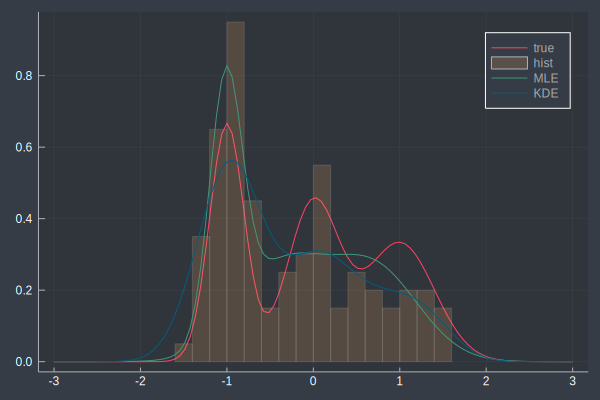

In [43]:
plot()
plot!(x, true_pdf, label="true")
histogram!(data, bins=20, alpha=0.2, normalize=true, label="hist")
plot!(x, true_pdf_fit, label="MLE")
plot!(x, pdf(kde_data, x), label="KDE")

# Mixture multiple dimension model MLE

In [44]:
μ_arr = [[2.; 2], [-2; -2], [2; -2]]
Σ_arr = [[1. 0.5; 0.5 1.], [1. 0; 0 1], [1 -0.5; -0.5 1]]
num_arr = [50, 30, 20]

3-element Array{Int64,1}:
 50
 30
 20

In [45]:
mat_arr = Matrix[]
for (μ, Σ, num) in zip(μ_arr, Σ_arr, num_arr)
    #println(μ, Σ, num)
    mat = rand(MvNormal(μ, Σ), num)  # 2 x num
    push!(mat_arr, mat)
end
data = hcat(mat_arr...)

2×100 Array{Float64,2}:
 2.15057  2.64107   2.26895  3.74687  …   0.5344    2.18645   1.53061
 1.132    0.956469  2.0206   2.56987     -1.40667  -2.18465  -1.174  

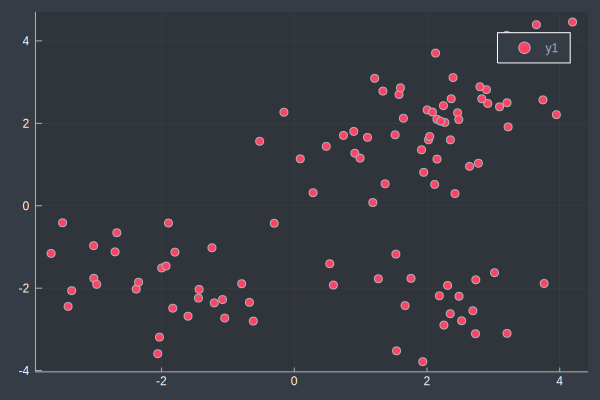

In [46]:
scatter(data[1,:], data[2,:])

In [47]:
likelihood = (μ_arr, σ_arr) -> begin
    dist_arr = [MvNormal(μ, σ) for (μ, σ) in zip(μ_arr, σ_arr)]
    num_classes = length(dist_arr)
    num_samples = size(data, 2)
    log_prior = log(1. / num_classes)
    lp = 0
    for d in 1:num_samples
        lp += logsumexp([logpdf(dist, data[:,d]) + log_prior for dist in dist_arr])
    end
    lp
end

#31 (generic function with 1 method)

In [48]:
encode = (p) -> begin
    μ_arr = Vector[]
    Σ_arr = Matrix[]
    for i in 1:3
        push!(μ_arr, p[(2*i-1):(2*i)])
        f = reshape(p[6+4*(i-1)+1:6+4*i], 2, 2)
        push!(Σ_arr, f' * f)
    end
    μ_arr, Σ_arr
end

#37 (generic function with 1 method)

In [49]:
f = (p) -> begin
    μ_arr, Σ_arr = encode(p)
    -likelihood(μ_arr, Σ_arr)
end

#39 (generic function with 1 method)

In [50]:
x0 = [randn(6); [1;0;0;1.]; [1;0;0;1.]; [1;0;0;1.]]

18-element Array{Float64,1}:
  0.3319091667148046
 -1.6433095219624725
 -0.7458544889135744
 -0.7459243343257457
 -0.6550476182144508
  1.8289442798916673
  1.0               
  0.0               
  0.0               
  1.0               
  1.0               
  0.0               
  0.0               
  1.0               
  1.0               
  0.0               
  0.0               
  1.0               

In [51]:
f(x0)

615.345389425848

In [52]:
res = optimize(f, x0, LBFGS(), autodiff=:forward)

 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [-4.16e-01, -2.01e+00, 2.01e+00,  ...]
    Minimum:   3.975467e+02

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [3.32e-01, -1.64e+00, -7.46e-01,  ...]

 * Convergence measures
    |x - x'|               = 9.89e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.01e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.71e-13 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.29e-16 ≰ 0.0e+00
    |g(x)|                 = 4.52e-06 ≰ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    272
    f(x) calls:    886
    ∇f(x) calls:   886


In [53]:
res = optimize(f, x0, )

 * Status: failure (reached maximum number of iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.28e+00, -2.18e+00, -2.20e+00,  ...]
    Minimum:   3.737273e+02

 * Found with
    Algorithm:     Nelder-Mead
    Initial Point: [3.32e-01, -1.64e+00, -7.46e-01,  ...]

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≰ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    1000
    f(x) calls:    1332


In [54]:
res = optimize(f, x0, iterations=10000)

 * Status: success

 * Candidate solution
    Minimizer: [2.15e+00, -2.32e+00, -2.05e+00,  ...]
    Minimum:   3.649739e+02

 * Found with
    Algorithm:     Nelder-Mead
    Initial Point: [3.32e-01, -1.64e+00, -7.46e-01,  ...]

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   2  (vs limit Inf)
    Iterations:    3613
    f(x) calls:    4821


In [55]:
μ_arr_fit, Σ_arr_fit = encode(Optim.minimizer(res))
dist_arr_fit = [MvNormal(μ, Σ) for (μ, Σ) in zip(μ_arr_fit, Σ_arr_fit)]

3-element Array{MvNormal{Float64,PDMat{Float64,Array{Float64,2}},Array{Float64,1}},1}:
 FullNormal(
dim: 2
μ: [2.151822356603406, -2.315319978017564]
Σ: [0.6501771077022512 -0.12898110129028423; -0.12898110129028423 0.4968955916966953]
)
 
 FullNormal(
dim: 2
μ: [-2.0476516492012187, -1.8681425532978642]
Σ: [0.8100083035203361 -0.2611628201941864; -0.2611628201941864 0.6368959491108641]
)

 FullNormal(
dim: 2
μ: [1.9836294394227587, 1.9896007284861126]
Σ: [1.1255851119177147 0.5623401883267891; 0.5623401883267891 1.042561808182948]
)
     

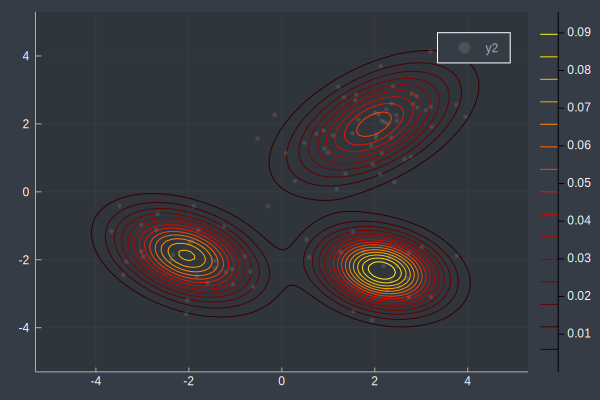

In [56]:
contour(range(-5,5,length=100), range(-5,5,length=100), (x,y)->begin
            mean([pdf(dist, [x;y]) for dist in dist_arr_fit])
        end)
scatter!(data[1,:], data[2,:], alpha=0.1, markersize=2)